In [1]:
import os
print(os.getcwd())

os.chdir('./data')

/home/rmi/JaeHwan/Deep_learning/Anterior/pinhole


# Pixel_Zscore

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from scipy import io
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import KFold
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import random

train = io.loadmat('thyroid_train_input_128x128_240pc_pixel_Zscore_att_4min_0_0.mat')
train_images = train['pixel_norm']
labels = io.loadmat('thyroid_train_label.mat')
train_labels = labels['pos_total_data']


# 데이터 셔플링을 위해 데이터와 레이블을 함께 합칩니다.
combined_data = list(zip(train_images, train_labels))

# 데이터를 랜덤하게 섞습니다.
np.random.shuffle(combined_data)

# 다시 데이터와 레이블을 분리합니다.
shuffled_images, shuffled_labels = zip(*combined_data)

# 넘파이 배열로 변환합니다.
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)

# mean = np.mean(train_images)
# std = np.std(train_images)
# train_images_normalized = (train_images - mean) / std

# mean = np.mean(train_labels)
# std = np.std(train_labels)
# train_labels_normalized = (train_labels - mean) / std

# train_images = train_images[0:98, :, :]
# train_labels = train_labels[0:98, :, :]

inputs = Input(shape=(128, 128, 1))

# def step_decay(epoch):
#     initial_lr = 0.0002  # 초기 learning rate 설정
#     drop = 0.5  # 감소 비율 설정
#     epochs_drop = 50  # 감소 주기 설정
#     lr = initial_lr * (drop ** (epoch // epochs_drop))
#     return lr

def create_unet_model():

    # Encoder
    conv0 = Conv2D(64, (11, 11), activation='relu', padding='same')(inputs)
    conv0 = BatchNormalization()(conv0)
    conv0 = Conv2D(64, (11, 11), activation='relu', padding='same')(conv0)
    conv0 = BatchNormalization()(conv0)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)

    conv1 = Conv2D(128, (11, 11), activation='relu', padding='same')(pool0)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(128, (11, 11), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(256, (11, 11), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(256, (11, 11), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(512, (11, 11), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(512, (11, 11), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(1024, (11, 11), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(1024, (11, 11), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2), interpolation='nearest')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(512, (11, 11), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (11, 11), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2), interpolation='nearest')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(256, (11, 11), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (11, 11), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2), interpolation='nearest')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(128, (11, 11), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (11, 11), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2), interpolation='nearest')(conv7)
    up8 = concatenate([up8, conv0], axis=3)
    conv8 = Conv2D(64, (11, 11), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (11, 11), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    outputs = Conv2D(1, (3, 3), activation='linear', padding='same')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

    return model
unet_model = create_unet_model()

# lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1)

Epoch 1/200
12/12 [==============================] - 17s 487ms/step - loss: 1.0826 - val_loss: 0.9617
Epoch 2/200
12/12 [==============================] - 5s 454ms/step - loss: 0.1984 - val_loss: 0.6795
Epoch 3/200
12/12 [==============================] - 5s 455ms/step - loss: 0.1343 - val_loss: 0.4577
Epoch 4/200
12/12 [==============================] - 5s 457ms/step - loss: 0.1082 - val_loss: 0.3388
Epoch 5/200
12/12 [==============================] - 5s 459ms/step - loss: 0.1182 - val_loss: 0.3012
Epoch 6/200
12/12 [==============================] - 5s 460ms/step - loss: 0.0897 - val_loss: 0.2631
Epoch 7/200
12/12 [==============================] - 6s 462ms/step - loss: 0.0837 - val_loss: 0.2360
Epoch 8/200
12/12 [==============================] - 6s 463ms/step - loss: 0.0755 - val_loss: 0.2070
Epoch 9/200
12/12 [==============================] - 6s 465ms/step - loss: 0.0759 - val_loss: 0.1945
Epoch 10/200
12/12 [==============================] - 6s 466ms/step - loss: 0.0634 - val_l

12/12 [==============================] - 6s 474ms/step - loss: 0.0115 - val_loss: 0.0150
Epoch 82/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0130 - val_loss: 0.0137
Epoch 83/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0118 - val_loss: 0.0133
Epoch 84/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0143 - val_loss: 0.0176
Epoch 85/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0137 - val_loss: 0.0162
Epoch 86/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0126 - val_loss: 0.0138
Epoch 87/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0113 - val_loss: 0.0161
Epoch 88/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0117 - val_loss: 0.0156
Epoch 89/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0118 - val_loss: 0.0140
Epoch 90/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0114 - val_loss: 

Epoch 161/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 162/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0063 - val_loss: 0.0081
Epoch 163/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 164/200
12/12 [==============================] - 6s 474ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 165/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 166/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 167/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0132 - val_loss: 0.0266
Epoch 168/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0089 - val_loss: 0.0220
Epoch 169/200
12/12 [==============================] - 6s 473ms/step - loss: 0.0095 - val_loss: 0.0108
Epoch 170/200
12/12 [==============================] - 6s 473ms/step - lo

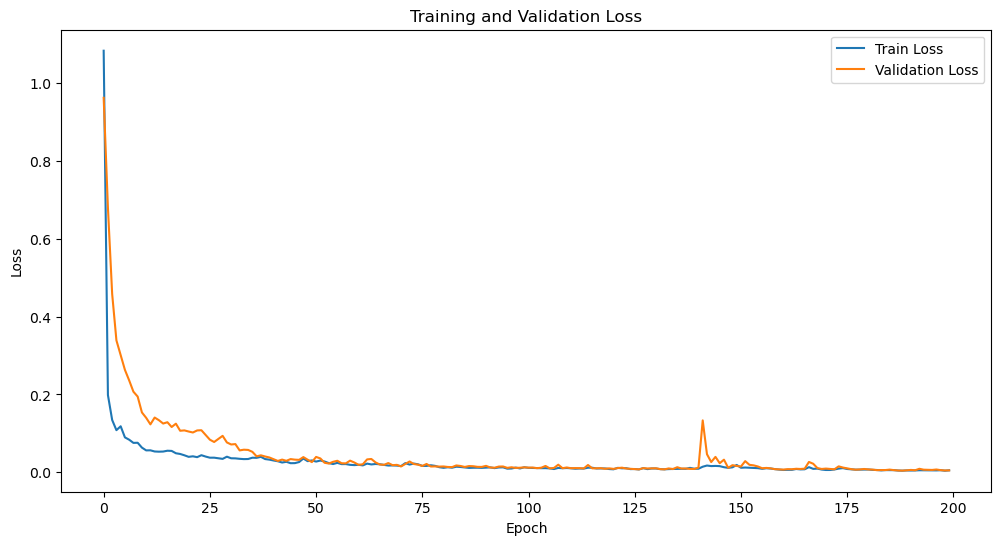

In [24]:
import matplotlib.pyplot as plt
import scipy.io as sio

# 모델 훈련
history = unet_model.fit(shuffled_images, shuffled_labels, epochs=200, batch_size=16, validation_split=0.2, callbacks=early_stopping) #, lr_scheduler])

# 손실 및 학습률 플로팅
plt.figure(figsize=(12, 6))

# 훈련 데이터 손실
# plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# # 학습률
# plt.subplot(1, 2, 2)
# plt.plot(history.history['lr'], label='Learning Rate')
# plt.title('Learning Rate Schedule')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.yscale('log')  # 학습률을 로그 스케일로 표시
# plt.legend()

# plt.tight_layout()
# plt.show()

# mat 파일에 저장할 데이터
data = {
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss']
}

# mat 파일로 저장
sio.savemat('history_data_4min.mat', data)